# Code pipeline

In [1]:
# !pip install tai-chi-engine

## Probable other dependencies
transformers==4.12.3

In [33]:
from forgebox.imports import *
from tai_chi_engine import TaiChiEngine

## Demo tasks

> Load all the code above in one shot, the demo starts here

In [3]:
def df_creator_image_folder(path: Path) -> pd.DataFrame:
    """
    Create a dataframe ,
    Which list all the image path under a system folder
    """
    path = Path(path)
    files = []
    formats = ["jpg", "jpeg", "png"]
    for fmt in formats:
        files.extend(path.rglob(f"*.{fmt.lower()}"))
        files.extend(path.rglob(f"*.{fmt.upper()}"))
    return pd.DataFrame({"path": files}).sample(frac=1.).reset_index(drop=True)

### Choose dataset

In [35]:
# BEAR_DATASET = HOME/"Downloads"/"bear_dataset"
DATA = Path("/GCI/data")
BEAR_DATASET = DATA/"bear_dataset"
ROTTEN_TOMATOES = DATA/"rttmt"
NETFLIX = DATA/"nf"

Choose one of the following to run 

#### Netflix 📺

In [36]:
base_df = pd.read_csv(NETFLIX/"netflix_titles.csv")
base_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


#### The bear 🐻

In [ ]:
base_df = df_creator_image_folder(BEAR_DATASET)
base_df

#### The rotten tomatoes 🍅 🎬

In [ ]:
# the rotten tomatoes dataset, we are not using every line

base_df = pd.read_csv(ROTTEN_TOMATOES/'critic_reviews.csv', nrows=200000)
base_df = base_df[~base_df['review_score'].isna()].reset_index(drop=True)
base_df = base_df[~base_df['review_content'].isna()].reset_index(drop=True)
base_df = base_df[~base_df['critic_name'].isna()].reset_index(drop=True)

base_df = base_df[base_df['review_score'].apply(lambda x: "/" in x)].reset_index(drop=True)

base_df['review_score'] = base_df['review_score'].apply(eval)

base_df

### Start of the pipeline

Initiate the ```phase``` to track the configuration

In [37]:
# PROJECT = Path("./project")
# PROJECT = Path("./project/image_regression")
# PROJECT = Path("./project/rotten1")
# PROJECT = Path("./project/rotten_text")
PROJECT = Path("./netflix")
# PROJECT = Path("./project0")
# PROJECT = Path("./playground")

# engine = TaiChiEngine(base_df, project = PROJECT)

In [19]:
# engine()

## No interactive, all code pipeline

In [8]:
from tai_chi_tuna.config import PhaseConfig
from tai_chi_tuna.flow.to_enrich import set_enrich, execute_enrich
from tai_chi_tuna.flow.to_quantify import (
    execute_quantify, TaiChiDataset, choose_xy, 
    save_qdict, load_qdict
    )
from tai_chi_tuna.flow.to_model import TaiChiDataModule, assemble_model
from tai_chi_tuna.flow.to_train import (
    make_slug_name, set_trainer, run_training)

In [30]:
from tai_chi_engine import TaiChiEngine

In [10]:
phase = PhaseConfig.load(PROJECT)

Excute Enrichment and create dataset

In [11]:
base_df = execute_enrich(base_df, phase, enrichments=TaiChiEngine.enrichments_map)
ds = TaiChiDataset(base_df)

Define the data transformation (into tensor), and create the **datamodule**

In [12]:
qdict = execute_quantify(df=base_df, phase=phase, quantify_map=TaiChiEngine.quantify_map)
# save quantify objects
_ = save_qdict(phase.project, qdict)

datamodule = TaiChiDataModule(ds, qdict)
datamodule.configure(**phase['batch_level'])

0it [00:00, ?it/s]

Assemble the **model**

In [13]:
module_zoo = {"all_entry": TaiChiEngine.all_entry, "all_exit": TaiChiEngine.all_exit}
final_model = assemble_model(phase, qdict, module_zoo)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Save the configuration so far

In [14]:
phase['task_slug'] = make_slug_name(phase)
phase.save()

Run the **Training**

In [15]:
run_training(phase, final_model, datamodule)(dict())

/anaconda3/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: Checkpoint directory netflix/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()


  | Name       | Type             | Params
------------------------------------------------
0 | entry_dict | EntryDict        | 110 M 
1 | exit_part  | MultiCategoryTop | 33.6 K
------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.728   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:349: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f'Your {mode}_dataloader has `shuffle=True`, it is best practice to turn'
/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cp

Training: 0it [00:00, ?it/s]

/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


## Inference Pipeline

### Bear inference

In [2]:
from tai_chi_engine import TaiChiTrained
from pathlib import Path

In [16]:
PROJECT = Path("./project")
trained = TaiChiTrained(PROJECT)
trained

[☯️ Project: project]
	model:	self.final_model
	quantify:	self.qdict
	x_columns:	['image']
	y_columns:	['label']

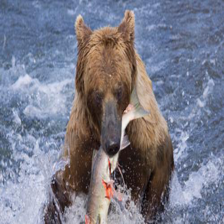

In [8]:
from PIL import Image
img = Image.open("/GCI/data/bear_dataset/grizzly/00000099.jpg").convert('RGB').resize((224,224))
img

In [9]:
trained.predict({"image":img})

,category,score
0,grizzly,0.999911
1,teddys,0.000078
2,black,0.000011


In [ ]:
trained.phase

In [ ]:
trained.qdict['label'].category.i2c

### Netflix inference

In [12]:
from tai_chi_engine import TaiChiTrained
from pathlib import Path

PROJECT = Path("./netflix")
trained = TaiChiTrained(PROJECT)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
trained

[☯️ Project: netflix]
	model:	self.final_model
	quantify:	self.qdict
	x_columns:	['description', 'cast']
	y_columns:	['listed_in']

In [14]:
data = {
    "description":"This movie tells a story of a freelancer jounalist found her romance when she first move into the west coast",
    "cast":"Jennifer Aniston,Paul Rudd"
}

In [15]:
trained.predict(data)

,category,score
0,International Movies,0.450314
1,Dramas,0.327208
2,Comedies,0.193359
3,International TV Shows,0.125960
4,Action & Adventure,0.111700
5,Independent Movies,0.089336
6,Horror Movies,0.086978
7,TV Dramas,0.079641
8,Romantic Movies,0.079597
9,Thrillers,0.071450
